In [1]:
import datetime, time, pickle  

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from datetime import datetime

import numpy as np
import pickle, datetime
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b

path = r'/Users/Guille/Desktop/data_processing/data/{}'

# Pyranometer Measuremetns Attenuation Bias Model

In [2]:
def load_data(path, name):
    file = path.format(name)
    
    with open(file, 'rb') as f:
        X = pickle.Unpickler(f).load()
        Y = pickle.Unpickler(f).load()
        Z = pickle.Unpickler(f).load()
        W = pickle.Unpickler(f).load()            
    return X, Y, Z, W

X, Y, Z, W = load_data(path, name = 'clear_sky_solar_normal_radiation_fit.pkl')

Z = Z[:, np.newaxis] 
W = W[:, np.newaxis]
print(X.shape, Y.shape, Z.shape, W.shape)

(53, 1) (53, 3) (53, 1) (53, 1)


(53, 1) (53, 1)
[[342 347 354 104  11 162  99  61 266 139 173  24 175  62 108  94 353  42
  136  38 176  13 349 158 343 346  60 202  63 312 255  27 143  22 199  33
  144]]
53 37 16 (37,) (16,)


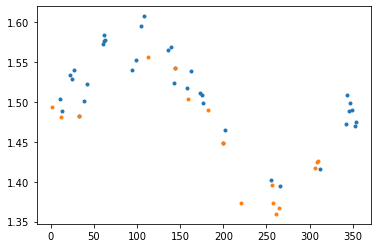

[9.14666540e-02 5.47271453e-18 1.49130810e+00]
0.028870542339456063
[0.0824619  0.00500466 1.49321637]
0.03219872275768662


In [3]:
# Function model
def _f(d_, A, B, C, N = 365.):
    return A * np.sin(B + ( (2*np.pi)/N) * d_) + C

# Gradiante of the error function
def _G(*var):
    # Thetas
    a = var[0][0]
    b = var[0][1]
    c = var[0][2]
    # Variables
    y_ = var[2]
    d_ = var[1]
    # Constants
    N = 365.
    n = y_.shape[0]

    y_hat_ = _f(d_, a, b, c)
    c  = - (1./n) * ( (y_ - y_hat_) / abs(y_ - y_hat_) )
    
    g1 = c * np.sin(b + ( (2*np.pi)/N ) * d_)
    g2 = c * a * np.sin(b + ( (2*np.pi)/N ) * d_)
    g3 = c * 1.
    
    return np.array((g1.sum(), g2.sum(), g3.sum()))

# Error Function
def _RMSE(*var):
    # Thetas
    a = var[0][0]
    b = var[0][1]
    c = var[0][2]
    # Variables
    y_ = var[2]
    d_ = var[1]
    # Make a prediction
    y_hat_ = _f(d_, a, b, c)
    # Compute Error
    return np.sqrt(np.mean((y_ - y_hat_)**2))

# Implementation of the line search gradient based optimization method
def _L_BFGS(_f, _g, x_tr_, y_tr_, x_0_, bounds_, n_restarts_optimizer = 5):
    # Random initialization of the line search for each kernel hyper-parameter within the bounds.
    def __random_initialization(bounds_):
        D = len(bounds_)
        x_k_ = np.zeros(D)
        for i in range(D):
            x_k_[i] = np.random.uniform(bounds_[i][0], bounds_[i][1])
        return x_k_
    f_eval = []
    x_eval = []
    i = 1
    while i < n_restarts_optimizer:  
    
        x_0_ = __random_initialization(bounds_)

        # Run the line search BFGS optimization!
        OPT = fmin_l_bfgs_b(_f, x0 = x_0_, fprime = _g, args = (x_tr_, y_tr_), 
                            bounds = bounds_, maxfun = 15000, approx_grad = False)
            
        if not np.isnan(OPT[1]):
            i+=1
            f_eval.append(OPT[1])
            x_eval.append(OPT[0])

    i     = np.argmin(f_eval)
    f_opt = f_eval[i]
    x_opt = x_eval[i]
    return f_opt, x_opt, i

def _LOO(d_tr_, s_tr_):
    N      = s_tr_.shape[0]
    idx_   = np.arange(N, dtype = int)
    # Optimization Parameters
    x_0_    = np.array([0., 0., 0])
    bounds_ = [(0., 10.), (0., 5.), (0., 2.)]
    # Variable Initialization
    error_ = np.zeros((1, N))
    theta_ = np.zeros((3, N))
    for i in range(N):
        # Get train Index
        idx_tr_ = np.delete(idx_, i)
        # Run Parameters Optimization
        opt_ = _L_BFGS(_RMSE, _G, d_tr_[idx_tr_], s_tr_[idx_tr_], x_0_, bounds_, n_restarts_optimizer = 25)
        # Get Parameters
        theta_[0, i] = opt_[1][0]
        theta_[1, i] = opt_[1][1]
        theta_[2, i] = opt_[1][2]
        # Get Validation Error
        y_hat_val_   = _f(d_tr_[i], A = theta_[0, i], B = theta_[1, i], C = theta_[2, i])
        error_[0, i] = np.sqrt( np.mean(( y_hat_val_ - s_tr_[i] )**2 ))
    return np.mean(theta_, axis = 1)


def _fit(d_, s_, _f, _g):
    theta_  = np.zeros((3))
    x_0_    = np.array([0., 0., 0])
    bounds_ = [(0., 10.), (0., 5.), (0., 2.)]
    opt_    = _L_BFGS(_f, _g, d_, s_, x_0_, bounds_, n_restarts_optimizer = 5)
    # Get Parameters
    theta_[0] = opt_[1][0]
    theta_[1] = opt_[1][1]
    theta_[2] = opt_[1][2]
    return theta_

d_ = Z.copy()
s_ = W.copy()
N = s_.shape[0]
print(d_.shape, s_.shape)
N_tr = int(N*0.7)
N_ts = N - N_tr
idx_ = np.linspace(0, N - 1, dtype = int)
idx_ = np.random.permutation(idx_)
idx_tr_ = idx_[:N_tr]
idx_ts_ = idx_[-N_ts:]
print(d_[idx_tr_].T)
print(N, N_tr, N_ts, idx_tr_.shape, idx_ts_.shape)

plt.figure()
plt.plot(d_[idx_tr_], s_[idx_tr_], '.')
plt.plot(d_[idx_ts_], s_[idx_ts_], '.')
plt.show()

theta_ = _fit(d_[idx_tr_], s_[idx_tr_], _f = _RMSE, _g = _G)
print(theta_)
y_hat_ts_ = _f(d_[idx_ts_], A = theta_[0], B = theta_[1], C = theta_[2])
e = np.sqrt( np.mean(( np.squeeze(y_hat_ts_) - np.squeeze(s_[idx_ts_]) )**2 ))
print(e)

theta_ = _LOO(d_[idx_tr_], s_[idx_tr_])
print(theta_)
y_hat_ts_ = _f(d_[idx_ts_], A = theta_[0], B = theta_[1], C = theta_[2])
e = np.sqrt( np.mean(( np.squeeze(y_hat_ts_) - np.squeeze(s_[idx_ts_]) )**2 ))
print(e)

(53, 1)
(1095, 1) (1095, 1)
(365, 1) (365, 1)


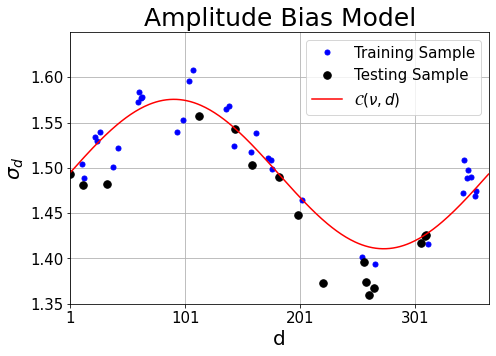

In [4]:
# Maker a Prediction
idx_ = np.squeeze((Z < 365) & (Z > 0.))
print(Z[idx_].shape)
x_ = np.linspace(-365, 2*365, 3*365)[:, np.newaxis]
y_ = _f(x_, A = theta_[0], B = theta_[1], C = theta_[2])
print(x_.shape, y_.shape)
x_hat_ = x_[np.squeeze((x_ < 365) & (x_ > 0.))]
y_hat_ = y_[np.squeeze((x_ < 365) & (x_ > 0.))]
print(x_hat_.shape, y_hat_.shape)

plt.rcParams.update({'font.size': 20})
plt.figure(figsize = (7.5, 5))
plt.title('Amplitude Bias Model', fontsize = 25)
plt.plot(d_[idx_tr_], s_[idx_tr_], 'b.', markersize = 10, label = r'Training Sample')
plt.plot(d_[idx_ts_], s_[idx_ts_], 'k.', markersize = 15, label = r'Testing Sample')
plt.plot(x_hat_, y_hat_, 'r-', label = r'$\mathcal{C} ( \nu, d )$')
plt.xlabel(r'd', fontsize = 20)
plt.ylabel(r'$\sigma_d$', fontsize = 20)
plt.ylim(1.35, 1.65)
plt.xlim(1, 365)
plt.yticks(np.arange(1.35, 1.65, .05), fontsize = 15)
plt.xticks(np.arange(d_.min(), d_.max(), 100), fontsize = 15)
plt.legend(prop = {'size': 15})
plt.grid()
plt.show()

# Pyranometer Measuremetns Shifting Bias Model

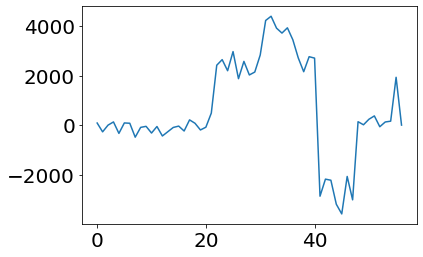

[[datetime.datetime(2017, 12, 8, 8, 8, 11, 5904)]
 [datetime.datetime(2017, 12, 9, 8, 8, 55, 212962)]
 [datetime.datetime(2017, 12, 12, 8, 11, 0, 5739)]
 [datetime.datetime(2017, 12, 13, 8, 11, 39, 4463)]
 [datetime.datetime(2017, 12, 15, 8, 12, 54, 7426)]
 [datetime.datetime(2017, 12, 19, 8, 15, 9, 7693)]
 [datetime.datetime(2017, 12, 20, 8, 15, 39, 8331)]
 [datetime.datetime(2018, 1, 1, 8, 19, 46, 5015)]
 [datetime.datetime(2018, 1, 11, 8, 20, 10, 4544)]
 [datetime.datetime(2018, 1, 12, 8, 20, 3, 5042)]
 [datetime.datetime(2018, 1, 13, 8, 19, 54, 5823)]
 [datetime.datetime(2018, 1, 22, 8, 17, 16, 10969)]
 [datetime.datetime(2018, 1, 24, 8, 16, 22, 5041)]
 [datetime.datetime(2018, 1, 27, 8, 14, 49, 5232)]
 [datetime.datetime(2018, 2, 2, 8, 10, 58, 6303)]
 [datetime.datetime(2018, 2, 7, 8, 7, 3, 1555)]
 [datetime.datetime(2018, 2, 11, 8, 3, 28, 1646)]
 [datetime.datetime(2018, 2, 26, 7, 47, 5, 1206)]
 [datetime.datetime(2018, 3, 1, 7, 43, 20, 1891)]
 [datetime.datetime(2018, 3, 2, 7, 4

In [5]:
def load_data(path, name):
    file = path.format(name)
    
    with open(file, 'rb') as f:
        X = pickle.Unpickler(f).load()
        Y = pickle.Unpickler(f).load()           
    return X, Y

Z, W = load_data(path, name = 'clear_sky_ghi.pkl')
Z = Z[:, np.newaxis] 
W = W[:, np.newaxis]

plt.figure()
plt.plot(W)
plt.show()

print(Z)

N = Z.shape[0]
O = np.linspace(1, N, N)[:, np.newaxis]
print(Z.shape, W.shape, O.shape)

for i in range(0, len(Z)):
    Z[i][0] = Z[i][0].timetuple().tm_yday

In [6]:
i = np.where(Z == 1)[0][0]
z_1_ = Z[:i]
z_2_ = Z[i:]
print(z_1_.T)
print(z_2_.T)
x_1_ = np.linspace(z_1_.min(), 365, 365 - z_1_.min() + 1)
x_2_ = np.linspace(z_2_.min(), z_2_.max(), 365)
print(x_1_.T)
print(x_2_.T)
x_ = np.concatenate((x_1_, x_2_), axis = 0)
print(x_.shape)

i = np.where(x_ == 1)[0][0]
x_[:i] -= 365
print(x_)

i = np.where(Z == 1)[0][0]
Z[:i] -= 365

[[342 343 346 347 349 353 354]]
[[1 11 12 13 22 24 27 33 38 42 57 60 61 62 63 94 99 104 108 113 136 139
  143 144 158 159 162 163 173 175 176 182 199 202 221 255 256 258 261 265
  266 306 309 310 311 312 328 331 343 365]]
[342. 343. 344. 345. 346. 347. 348. 349. 350. 351. 352. 353. 354. 355.
 356. 357. 358. 359. 360. 361. 362. 363. 364. 365.]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 

(57, 1) (57, 1)
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 16 17 18 19 20 21 22 24 25 26
 27 28 29 30 32 33 34 35 36 37 38 40 41 42 43 44 45 46 48 49 50 51 52 53
 54 56]
57 39 18 (39,) (18,)
[[139 -22 143 113 162 22 306 255 173 221 94 24 311 310 61 309 159 -19]]


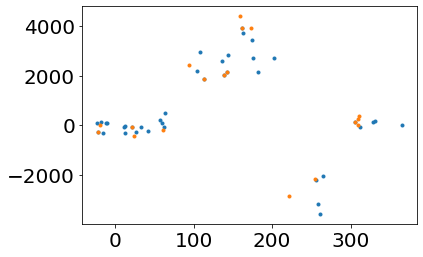

-39.1764705882353 2713.769230769231 -2771.75 0.38974358974358975
673.2516897051894
-39.17647058823531 2713.769230769231 -2771.75 0.3898110661268557
673.2516854988693


In [7]:
def _pieceswise_model(dt_, d_, d_1, d_2, d_3, d_4):
    y_1 = np.mean(dt_[d_ < d_1])
    y_2 = np.mean(dt_[(d_ > d_1) & (d_ < d_2)])
    y_3 = np.mean(dt_[(d_ > d_2) & (d_ < d_3)])
    y_4 = np.mean(dt_[d_ > d_3] & (d_ < d_4))
    return y_1, y_2, y_3, y_4

def _predict(x_, y_1, y_2, y_3, y_4, d_1, d_2, d_3, d_4):
    y_hat_ = x_.copy()
    y_hat_[x_ <= d_1] = y_1
    y_hat_[x_ > d_1]  = y_2
    y_hat_[x_ > d_2]  = y_3
    y_hat_[x_ > d_3]  = y_4
    y_hat_[x_ > d_4]  = 0
    return y_hat_

def _LOO(dt_tr_, d_tr_):
    N      = dt_tr_.shape[0]
    idx_   = np.arange(N, dtype = int)
    theta_ = np.zeros((4, N))
    error_ = np.zeros((1, N))
    for i in idx_:
        idx_tr_  = np.delete(idx_, i)
        y_1, y_2, y_3, y_4 = _pieceswise_model(dt_tr_[idx_tr_], d_tr_[idx_tr_], d_1 = 72, d_2 = 220, d_3 = 305, d_4 = 340)
        y_hat_val_ = _predict(d_tr_[i], y_1, y_2, y_3, y_4, d_1 = 72, d_2 = 220, d_3 = 305, d_4 = 340)
        error_[:, i] = np.sqrt( np.mean(( np.squeeze(y_hat_val_) - np.squeeze(dt_tr_[i]) )**2 ))
        theta_[:, i] = np.array((y_1, y_2, y_3, y_4 ))
    return np.mean(theta_, axis = 1)

N = W.shape[0]
dt_ = W
d_  = Z
print(dt_.shape, d_.shape)

N_tr = int(N*0.7)
N_ts = N - N_tr
idx_ = np.linspace(0, N - 1, dtype = int)
print(idx_)
idx_ = np.random.permutation(idx_)
idx_tr_ = idx_[:N_tr]
idx_ts_ = idx_[-N_ts:]
print(N, N_tr, N_ts, idx_tr_.shape, idx_ts_.shape)
print(d_[idx_ts_].T)
plt.figure()
plt.plot(d_[idx_tr_], dt_[idx_tr_], '.')
plt.plot(d_[idx_ts_], dt_[idx_ts_], '.')
plt.show()

y_1, y_2, y_3, y_4 = _pieceswise_model(dt_[idx_tr_], d_[idx_tr_], d_1 = 72, d_2 = 220, d_3 = 305, d_4 = 340)
print(y_1, y_2, y_3, y_4)

y_hat_ts_ = _predict(d_[idx_ts_], y_1, y_2, y_3, y_4, d_1 = 72, d_2 = 220, d_3 = 305, d_4 = 340)
e = np.sqrt( np.mean(( np.squeeze(y_hat_ts_) - np.squeeze(dt_[idx_ts_]) )**2 ))
print(e)

y_1, y_2, y_3, y_4 = _LOO(dt_[idx_tr_], d_[idx_tr_])
print(y_1, y_2, y_3, y_4)
y_hat_ts_ = _predict(d_[idx_ts_], y_1, y_2, y_3, y_4, d_1 = 72, d_2 = 220, d_3 = 305, d_4 = 340)
e = np.sqrt( np.mean(( np.squeeze(y_hat_ts_) - np.squeeze(dt_[idx_ts_]) )**2 ))
print(e)

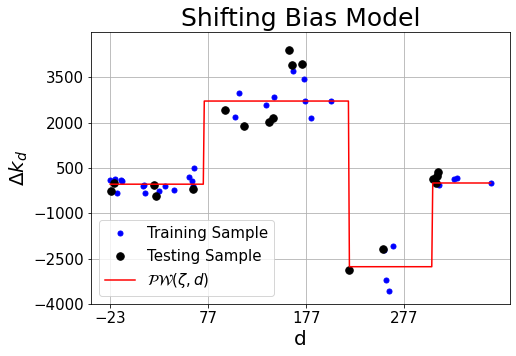

In [8]:
y_ = _predict(x_, y_1, y_2, y_3, y_4, d_1 = 72, d_2 = 220, d_3 = 305, d_4 = 340)

plt.rcParams.update({'font.size': 20})
plt.figure(figsize = (7.5, 5))
plt.title('Shifting Bias Model', fontsize = 25)
plt.plot(d_[idx_tr_], dt_[idx_tr_], 'b.', markersize = 10, label = r'Training Sample')
plt.plot(d_[idx_ts_], dt_[idx_ts_], 'k.', markersize = 15, label = r'Testing Sample')
plt.plot(x_, y_, 'r-', label = r'$\mathcal{PW} (\zeta, d)$')
plt.xlabel(r'd', fontsize = 20)
plt.ylim(-4000, 5000)
plt.ylabel(r'$\Delta k_d$', fontsize = 20)
plt.yticks(np.arange(-4000, 5000, 1500), fontsize = 15)
plt.xticks(np.arange(d_.min(), d_.max(), 100), fontsize = 15)
plt.legend(prop={'size': 15})
plt.grid()
plt.show()